<div dir=rtl>

نام و نام‌خانوادگی: حامد آجورلو  

شماره دانشجویی: 97101167

----



:<div dir=rtl>

#  آزمايش اول: بخش‌بندی معنايی تصوير 

----



<div dir=rtl>


در اين آزمايش می‌خواهيم با استفاده از الگوريتم U-Net بخش‌بندی معنايی تصوير را پياده‌سازی کنيم.

برای دریافت دیتاست به لینک روبه رو مراجعه کنید:
 [دیتاست](https://drive.google.com/drive/folders/1-BR6XJjjHWFd1WJ3S75Z_-tdgee7T2zW?usp=sharing)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os 
import imageio as image
import imageio
from PIL import Image
import matplotlib.pyplot as plt
import cv2 
import numpy as np

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

<div dir=rtl>

## 1.	آشنایی با دیتاست

آشنايی با ديتاست: درون لينک ديتاست دو فولدر با نام‌های image وmask قرار دارد. فولدر image شامل تصاوير اصلی و فولدر mask، ماسک مربوط به هر تصوير را شامل می‌شود. 

ابتدا مانند نمونه بالا، 3 نمونه از تصاوير ديتاست را به همراه ماسک‌هايشان نمايش دهيد.

In [ ]:
### Load Data
pictures = {}
masks = {}
image_Address = '/content/drive/MyDrive/segmentation_dataset/images/'
mask_Address = '/content/drive/MyDrive/segmentation_dataset/mask/'
## making pictures and relevant masks dataset
i = 0
for elements in os.listdir(image_Address) :
  if(i == 1500):
    break
  path1 = image_Address + str(elements)
  path2 = mask_Address + str(elements)[0:-3] + 'png'
  im = image.imread(path1)
  if (np.shape(im)[-1] != 3):
    continue
  pictures[str(elements)[0:-3]] = im
  mask = image.imread(path2)
  masks[str(elements)[0:-3]] = mask
  i=i+1



<div dir=rtl>

## 2. پیش‌پردازش

همانطور که مشاهده کرديد، تصاوير موجود در ديتاست، هر يک دارای ابعاد متفاوتی هستند. برای برطرف نمودن اين مشکل، ابعاد تمامی تصاوير و ماسک‌های مربوط به آنها را به 128x128 تغيير دهيد. همچنين دقت نماييد تصاوير اصلی دارای 3کانال(RGB) و ماسک‌ها دارای 1 کانال هستند.

پیش‌پردازش‌های موردنیاز:

* تغییر ابعاد تصیر و ماسک به ۱۲۸*۱۲۸
* نرمالیزه کردن تصویر 
* تبدیل مقادیر ماسک به کلاس‌های ۰،۱ و ۲

In [ ]:
### function to preprocess data: resize + normalize + mask to 3 class label
def preprocess(pictures, masks):
  X = np.zeros((1500,128,128,3))
  y = np.zeros((1500,128,128))
  i=0
  for key in pictures.keys():
    if(i == 1500):
      break
    img = pictures[key]
    mask = masks[key]
    X[i,:,:,:] = cv2.resize(img,(128,128),interpolation = cv2.INTER_AREA)/255
    y[i,:,:] = np.floor(cv2.resize(mask,(128,128),interpolation=cv2.INTER_AREA)/90)
    i+=1
  return X, y

X, y = preprocess(pictures, masks)
## designing a function to preprocess images
## resize + classifying into 3 classes


<div dir=rtl>


یکی از تصاویر و ماسک مربوط به آن را بعد از پیش‌پردازش نمایش دهید
.

(-0.5, 255.5, 255.5, -0.5)

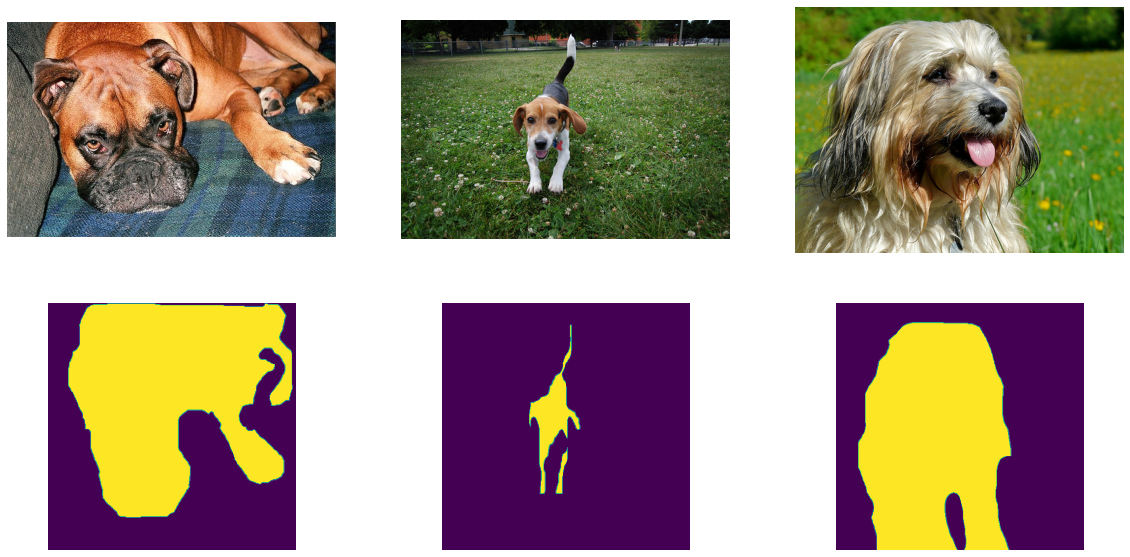

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(pictures[list(pictures.keys())[0]])
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(pictures[list(masks.keys())[1]])

plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(pictures[list(pictures.keys())[2]])
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(masks[list(masks.keys())[0]])
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(masks[list(pictures.keys())[1]])
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(masks[list(masks.keys())[2]])
plt.axis('off')
## plotting 3 images and their masks

<div dir=rtl>

## 3. داده‌های آموزش و تست:

*	برای تعريف داده‌های ورودی و خروجی، تصاوير اصلی را به‌عنوان ورودی شبکه و ماسک‌ها را به‌عنوان خروجی شبکه تعريف کنيد.

*	بعد از مشخص نمودن ورودی و خروجی شبکه، 20 درصد داده‌ها را به‌عنوان داده‌های تست و 80 درصد را به‌عنوان داده‌های آموزش قرار دهيد.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2 , random_state = 42)
## train test split

<div dir=rtl>

## 4. تعریف مدل

مدل U-Net را با استفاده از توضيحات ارائه شده در داخل دستور کار تعريف کنيد.

*	تمامی توابع فعالساز را به صورت relu تعريف کرده و padding را برابر same قرار دهيد.



In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
    
    conv = BatchNormalization()(conv, training=False)

    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection






In [ ]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose( n_filters, (3,3), strides=(2,2), padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    conv = Conv2D(n_filters, 3,  activation='relu',  padding='same', kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters, 3,  activation='relu',  padding='same', kernel_initializer='HeNormal')(conv)
    return conv

In [ ]:
def UNet(input_size=(128, 128, 3), n_filters=32, n_classes=3):

    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    ## making unet network
    cb1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cb2 = EncoderMiniBlock(cb1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cb3 =  EncoderMiniBlock(cb2[0],n_filters*4,dropout_prob=0, max_pooling=True)
    cb4 = EncoderMiniBlock(cb3[0],n_filters*8,dropout_prob=0.3, max_pooling=True)
    cb5 = EncoderMiniBlock(cb4[0],n_filters*16,dropout_prob=0.3, max_pooling=False)
    

    db1 = DecoderMiniBlock(cb5[0],cb4[1],n_filters*8)
    db2 = DecoderMiniBlock(db1,cb3[1],n_filters*4)
    db3 = DecoderMiniBlock(db2,cb2[1],n_filters*2)
    db4 = DecoderMiniBlock(db3,cb1[1],n_filters)


    conv9 = Conv2D(n_filters, 3,  activation='relu', padding='same', kernel_initializer='he_normal')(db4)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

unet = UNet(input_size=(128,128,3), n_filters=32, n_classes=3)

In [ ]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 128, 128, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_60[0][0]']              
                                )                                                           

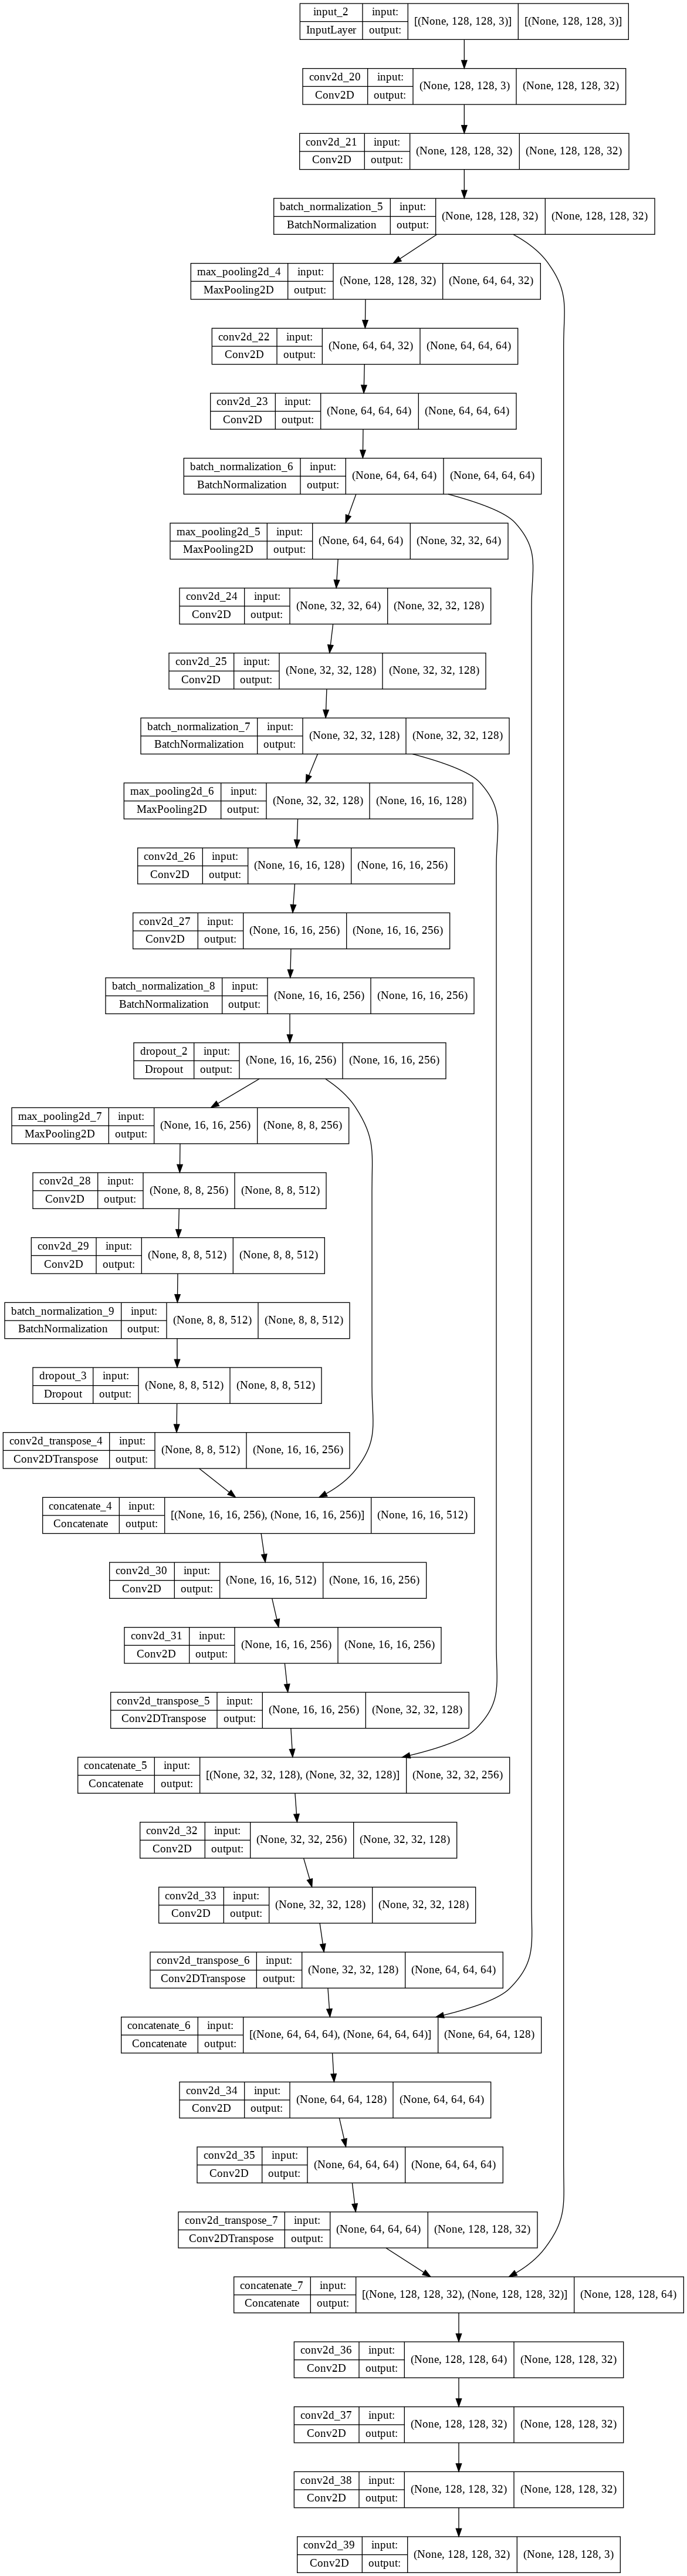

In [ ]:
tf.keras.utils.plot_model(unet, show_shapes=True)

<div dir=rtl>

## 5.	آموزش شبکه: شبکه را براساس پارامترهای زير آموزش دهيد:

•	تابع هزينه: SparseCategoricalCrossEntropy

•	بهينه‌ساز: Adam

•	تعداد تکرار: 30




In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
results = unet.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_valid, y_valid))


Epoch 1/30
38/38 [==============================] - 9s 203ms/step - loss: 0.7362 - accuracy: 0.6669 - val_loss: 0.6535 - val_accuracy: 0.7011
Epoch 2/30
38/38 [==============================] - 7s 192ms/step - loss: 0.6177 - accuracy: 0.6986 - val_loss: 0.5950 - val_accuracy: 0.7009
Epoch 3/30
38/38 [==============================] - 7s 195ms/step - loss: 0.5360 - accuracy: 0.7280 - val_loss: 0.4874 - val_accuracy: 0.7862
Epoch 4/30
38/38 [==============================] - 7s 197ms/step - loss: 0.4747 - accuracy: 0.7901 - val_loss: 0.4832 - val_accuracy: 0.7917
Epoch 5/30
38/38 [==============================] - 8s 199ms/step - loss: 0.4583 - accuracy: 0.8002 - val_loss: 0.4529 - val_accuracy: 0.8018
Epoch 6/30
38/38 [==============================] - 8s 201ms/step - loss: 0.4488 - accuracy: 0.8050 - val_loss: 0.4701 - val_accuracy: 0.8004
Epoch 7/30
38/38 [==============================] - 8s 202ms/step - loss: 0.4291 - accuracy: 0.8183 - val_loss: 0.4311 - val_accuracy: 0.8162
Epoch 

<div dir=rtl>

## 6.	تغييرات تابع هزينه و accuracy را در زمان آموزش برای داده‌های train و validation رسم کنيد و با توجه به آن به سؤالات زير پاسخ دهيد:

*	آيا بيش‌برازش هنگام آموزش شبکه رخ داده است؟

*	چه رابطه‌ای بين باياس و واريانس مدل با overfit و underfit بودن آن وجود دارد؟ تحليل کنيد.


خیر بیش برازش رخ نداده است و از آنجا که هم دقت مدل روی داده اعتبارسنجی و هم آموزش, صعودی و به سمت 1 بوده است نشان می دهد که مدل به خوبی آموزش دیده است.

بایاس زیاد می تواند باعث شود که مدل نتواند رابطه ی فیچرها و خروجی را به خوبی تشخیص دهد و به آموزش ضعیف مدل بیانجامد.واریانس زیاد از آنجا حاصل می شود که گویا مدل در حال آموزش جزییات ظریف داده آموزش شده است و از روند کلی جا مانده است که خبر از بیش برازش می دهد. می توان از دقت مدل بر روی داده آموزش و اعتبارسنجی
 به اورفیت یا اندر فیت شدن مدل پی برد که در اینجا هیچ یک رخ نداده و مدل به خوبی آموزش دیده است . چرا که هم مدل روند کلی موجود در داده آموزش را به خوبی یاد گرفته است و هم عملکرد خوبی رو داده اعتبارسنجی دارد 

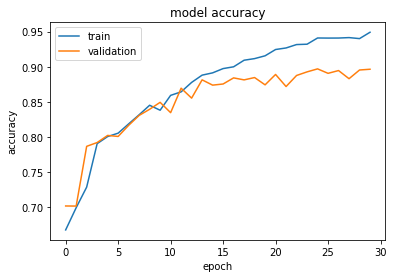

In [ ]:
####
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()

<div dir=rtl>

## 7.	خطای تست:

ماسک متناظر با داده‌های تست را محاسبه کرده و با توجه به خروجی آن، خطای تست را محاسبه کنيد.

In [ ]:
unet.evaluate(X_valid, y_valid)

10/10 [==============================] - 1s 62ms/step - loss: 0.3097 - accuracy: 0.8963


[0.30969786643981934, 0.8963263034820557]

<div dir=rtl>

## 8. مقایسه ماسک محاسبه شده و واقعی

سه نمونه از ماسک‌های محاسبه شده برای داده‌های تست را نمايش دهيد و با ماسک اصلی مقايسه کنيد. 

In [ ]:
# Results of Validation Dataset
def VisualizeResults(index):
  for i in range(index):
    plt.figure(figsize=(10,5))
    plt.subplot(1,index,1)
    plt.imshow(X_valid[i])
    plt.axis('off')
    plt.title('original img')
    plt.subplot(1,index,2)
    img = np.expand_dims(X_valid[i,:,:,:],axis=0)
    pred = unet.predict(img)
    plt.title('predicted mask')
    pred = np.argmax(unet.predict(img)[0] , axis = 2)
    plt.imshow(pred)
    plt.axis('off')
    plt.subplot(1,index,3)
    plt.imshow(y_valid[i])
    plt.title('original mask')
    plt.axis('off')

## visualizing predicted masks and comparing them to original masks

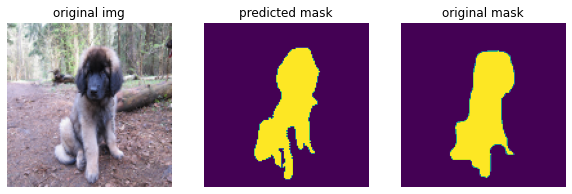

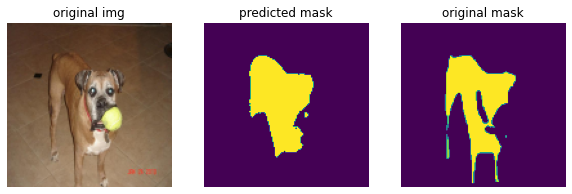

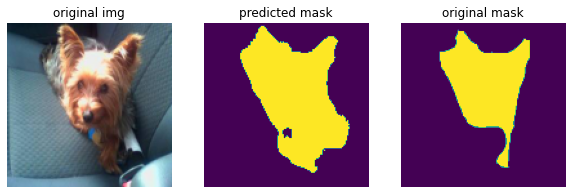

In [ ]:
VisualizeResults(3)

می بینیم که ماسک های بدست آمده تقریبا دقت کافی را دارا هستند و اگر بیش از 1500 تصویر را در روند آموزش استفاده کنیم قطعا به ماسک های بهتری می رسیم.